# Calculate seasonal ice concentration trends at all Arctic points

* **Description**: Reads in and creates spatial plots of wind trends
* **Input data**: CESM2-LE and Rufmod output in timeseries format
* **Output data**: PNG figures of trends
* **Creator**: Alice DuVivier
* **Date**: March 2022

The rufmod experiments were performed where the sea ice roughness over Arctic sea ice regions was set to be equal to what it would be over open ocean. This is to better understand ice-atmosphere coupling, processes, and feedbacks.

In [ ]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
import pop_tools
from datetime import timedelta
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from scipy import stats
from scipy.stats import linregress,pearsonr, t
import xesmf as xe

import dask
import intake
from distributed import Client
from ncar_jobqueue import NCARCluster

In [2]:
# spin up dask cluster

import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='32 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    #resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='P93300665', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.60:34705,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Manually set variables

In [4]:
# list the variables to load
var_in_1 = 'aice'

## Load rufmod experiments

In [5]:
# Load "rufmod" data
#choose cases and data paths
case1 = 'b.e21.BSSP370.f09_g17.rufmod.001'
case2 = 'b.e21.BSSP370.f09_g17.rufmod.002'
case3 = 'b.e21.BSSP370.f09_g17.rufmod.003'
case4 = 'b.e21.BSSP370.f09_g17.rufmod.004'
case5 = 'b.e21.BSSP370.f09_g17.rufmod.005'

# set base directory where all data live
data_dir = '/glade/campaign/cesm/development/pcwg/duvivier/arctic_cyclones/'
# set individual data directories
data_dir1 = data_dir+case1+'/ice/proc/tseries/month_1/'
data_dir2 = data_dir+case2+'/ice/proc/tseries/month_1/'
data_dir3 = data_dir+case3+'/ice/proc/tseries/month_1/'
data_dir4 = data_dir+case4+'/ice/proc/tseries/month_1/'
data_dir5 = data_dir+case5+'/ice/proc/tseries/month_1/'

In [6]:
%%time
#reading in files
print("loading "+var_in_1)   
ds1_1 = []
ds2_1 = []
ds3_1 = []
ds4_1 = []
ds5_1 = []
my_files=sorted(glob.glob(data_dir1+case1+'.cice.h.'+var_in_1+'.*.nc'))
ds1_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir2+case2+'.cice.h.'+var_in_1+'.*.nc'))
ds2_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir3+case3+'.cice.h.'+var_in_1+'.*.nc'))
ds3_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir4+case4+'.cice.h.'+var_in_1+'.*.nc'))
ds4_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir5+case5+'.cice.h.'+var_in_1+'.*.nc'))
ds5_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')

loading aice
CPU times: user 565 ms, sys: 274 ms, total: 838 ms
Wall time: 7.75 s


In [7]:
# concatenate them into a single array
futures_1 = xr.concat([ds1_1,ds2_1,ds3_1,ds4_1,ds5_1],dim='member_id')

In [8]:
# set member_id values
futures_1.member_id.values

# assign member_id as coordinate array
futures_1.assign_coords({"member_id": futures_1.member_id.values})

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 5, time: 1032, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id    (member_id) int64 0 1 2 3 4
Dimensions without coordinates: nj, ni, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, time, nc) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    VGRDi        (member_id, time, nkice) float32 dask.array<chunksize=(1, 600, 8), meta=np.ndarray>
    VGRDs        (member_id, time, nksnow) float32 dask.array<chunksize=(1, 600, 3), meta=np.ndarray>
    VGRDb        (member_id, time, nkbio) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    tmask        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    tarea        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 600, 2), meta=np.ndarray>
    aice         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BSSP370.f09_g17.rufmod.001
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20150201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2021-07-14 at 12:33
    io_flavor:         io_pio

In [9]:
futures_1

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 5, time: 1032, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: nj, ni, member_id, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, time, nc) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    VGRDi        (member_id, time, nkice) float32 dask.array<chunksize=(1, 600, 8), meta=np.ndarray>
    VGRDs        (member_id, time, nksnow) float32 dask.array<chunksize=(1, 600, 3), meta=np.ndarray>
    VGRDb        (member_id, time, nkbio) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    tmask        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    tarea        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 600, 2), meta=np.ndarray>
    aice         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BSSP370.f09_g17.rufmod.001
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20150201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2021-07-14 at 12:33
    io_flavor:         io_pio

In [10]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
futures_1['time'] = futures_1.time_bounds.load().mean(dim='d2').sel(member_id=0)

In [11]:
futures_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [12]:
ice_rufmod = futures_1[var_in_1]

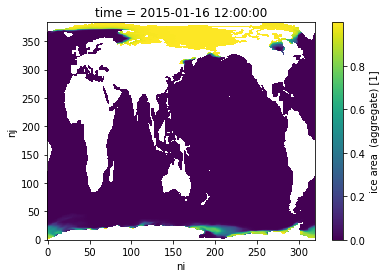

In [13]:
ice_rufmod.sel(member_id=0).isel(time=0).plot()

In [14]:
#mask just NH points
ice_masked_rufmod = ice_rufmod.isel(nj=slice(300,384))

# code below doesn't work properly - leads to NaNs that don't plot properly
#ice_masked_rufmod = ice_rufmod.where((ice_rufmod['TLAT']>50.0), drop=True)

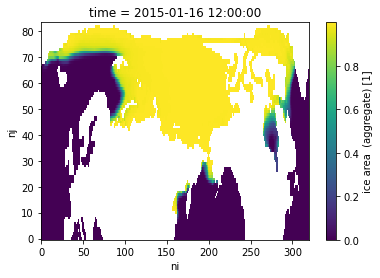

In [15]:
ice_masked_rufmod.sel(member_id=0).isel(time=0).plot()

In [16]:
ice_masked_rufmod.load()

<xarray.DataArray 'aice' (member_id: 5, time: 1032, nj: 84, ni: 320)>
array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
    TLON     (nj, ni) float32 320.6 321.7 322.8 323.9 325.0 ... nan nan nan nan
    TLAT     (nj, ni) float32 39.14 39.14 39.14 39.15 39.15 ... nan nan nan nan
    ULON     (nj, ni) float32 321.1 322.2 323.3 324.4 325.5 ... nan nan nan nan
    ULAT     (nj, ni) float32 39.35 39.35 39.35 39.36 39.37 ... nan nan nan nan
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: member_id, nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [17]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/analysis2/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [18]:
forcing = 'cmip6'  # do not want smbb data
expt = 'ssp370'
comp = 'ice'
freq = 'month_1'

subset_1 = cat.search(variable=var_in_1, forcing_variant=forcing, experiment=expt, component=comp, frequency=freq )

In [19]:
subset_1

,unique
component,1
stream,1
case,50
member_id,50
variable,1
start_time,9
end_time,9
time_range,9
long_name,1
units,1


In [20]:
subset_1.df.head()

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,aice,2015-01,2024-12,201501-202412,ice area (aggregate),1,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
1,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,aice,2025-01,2034-12,202501-203412,ice area (aggregate),1,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
2,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,aice,2035-01,2044-12,203501-204412,ice area (aggregate),1,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
3,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,aice,2045-01,2054-12,204501-205412,ice area (aggregate),1,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
4,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,aice,2055-01,2064-12,205501-206412,ice area (aggregate),1,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1


In [21]:
# check that we only have cmip6, not smbb, data
member_id = list(subset_1.df.experiment.unique())
print(member_id)

['ssp370']


In [22]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets_1 = subset_1.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 6.55 s, sys: 211 ms, total: 6.76 s
Wall time: 8.6 s


In [23]:
# load in the future datasets
futures_1 = []
for key in sorted(dsets_1.keys()):
    futures_1.append(dsets_1[key])
    print(key)
    

ice.ssp370.cice.h.cmip6.aice


In [24]:
future_ds_1 = xr.concat(futures_1, dim='member_id')

In [25]:
future_ds_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  model time
    bounds:     time_bounds

In [26]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
future_ds_1['time'] = future_ds_1.time_bounds.load().mean(dim='d2').sel(member_id='r1i1281p1f1')

In [27]:
ice_le = future_ds_1[var_in_1]

In [28]:
ice_le.persist()

<xarray.DataArray 'aice' (member_id: 50, time: 1032, nj: 384, ni: 320)>
dask.array<concatenate, shape=(50, 1032, 384, 320), dtype=float32, chunksize=(1, 120, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

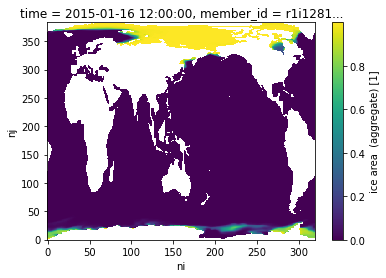

In [29]:
ice_le.sel(member_id='r1i1281p1f1').isel(time=0).plot()

In [30]:
#mask just NH points
ice_masked_le = ice_le.isel(nj=slice(300,384))

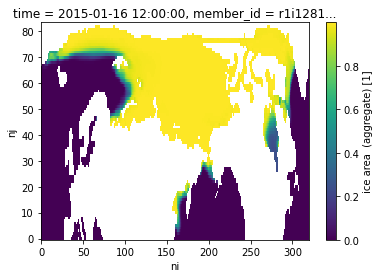

In [31]:
ice_masked_le.sel(member_id='r1i1281p1f1').isel(time=0).plot()

In [32]:
ice_masked_le

<xarray.DataArray 'aice' (member_id: 50, time: 1032, nj: 84, ni: 320)>
dask.array<getitem, shape=(50, 1032, 84, 320), dtype=float32, chunksize=(1, 120, 84, 320), chunktype=numpy.ndarray>
Coordinates:
    TLON       (nj, ni) float32 dask.array<chunksize=(84, 320), meta=np.ndarray>
    TLAT       (nj, ni) float32 dask.array<chunksize=(84, 320), meta=np.ndarray>
    ULON       (nj, ni) float32 dask.array<chunksize=(84, 320), meta=np.ndarray>
    ULAT       (nj, ni) float32 dask.array<chunksize=(84, 320), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [33]:
ice_masked_le.load()

<xarray.DataArray 'aice' (member_id: 50, time: 1032, nj: 84, ni: 320)>
array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
    TLON       (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT       (nj, ni) float32 39.14 39.14 39.14 39.15 ... nan nan nan nan
    ULON       (nj, ni) float32 321.1 322.2 323.3 324.4 ... nan nan nan nan
    ULAT       (nj, ni) float32 39.35 39.35 39.35 39.36 ... nan nan nan nan
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

## Because plotting aice, also want to convert to %

In [34]:
# convert to percentages instead of fraction
ice_masked_le = ice_masked_le*100.0
ice_masked_rufmod = ice_masked_rufmod*100.0

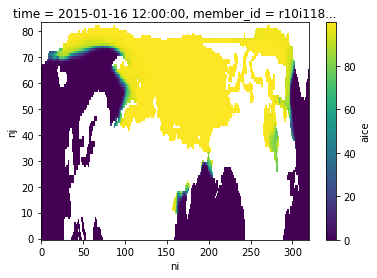

In [35]:
ice_masked_le[0,0,:,:].plot()

## Calculate seasonal means

In [36]:
season_names = ['OND','JFM', 'AMJ', 'JAS']

In [37]:
# find total years
xarr_le = ice_masked_le.coords['time.year'][(ice_masked_le.coords['time.month']==1)]
xarr_rufmod = ice_masked_rufmod.coords['time.year'][(ice_masked_rufmod.coords['time.month']==1)]

In [38]:
# Loop through seasons - rufmod
print('Calculating Seasonal Means - SMOOTH')

# make numpy array to fill and specify dimensions we want
seas_array_rufmod = np.zeros([len(season_names),len(xarr_rufmod),len(ice_masked_rufmod.member_id),len(ice_masked_rufmod.nj),len(ice_masked_rufmod.ni)])

for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp1 = ice_masked_rufmod.isel(time=ice_masked_rufmod.time.dt.month.isin([1,2,3]))
    if ss == 'AMJ':
        temp1 = ice_masked_rufmod.isel(time=ice_masked_rufmod.time.dt.month.isin([4,5,6]))
    if ss == 'JAS':
        temp1 = ice_masked_rufmod.isel(time=ice_masked_rufmod.time.dt.month.isin([7,8,9]))
    if ss == 'OND':
        temp1 = ice_masked_rufmod.isel(time=ice_masked_rufmod.time.dt.month.isin([10,11,12]))
    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_rufmod:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp2 = temp1.isel(time=temp1.time.dt.year.isin([yy]))
        temp3 = temp2.mean(dim='time')
        seas_array_rufmod[s_count,y_count,:,:,:] = temp3    


Calculating Seasonal Means - SMOOTH
OND
JFM
AMJ
JAS


In [39]:
# Loop through seasons - CESM2-LE
print('Calculating Seasonal Means - CESM2-LE')

# make numpy array to fill and specify dimensions we want
seas_array_le = np.zeros([len(season_names),len(xarr_le),len(ice_masked_le.member_id),len(ice_masked_le.nj),len(ice_masked_le.ni)])

for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp1 = ice_masked_le.isel(time=ice_masked_le.time.dt.month.isin([1,2,3]))
    if ss == 'AMJ':
        temp1 = ice_masked_le.isel(time=ice_masked_le.time.dt.month.isin([4,5,6]))
    if ss == 'JAS':
        temp1 = ice_masked_le.isel(time=ice_masked_le.time.dt.month.isin([7,8,9]))
    if ss == 'OND':
        temp1 = ice_masked_le.isel(time=ice_masked_le.time.dt.month.isin([10,11,12]))
    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_le:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp2 = temp1.isel(time=temp1.time.dt.year.isin([yy]))
        temp3 = temp2.mean(dim='time')
        seas_array_le[s_count,y_count,:,:,:] = temp3    


Calculating Seasonal Means - CESM2-LE
OND
JFM
AMJ
JAS


In [40]:
print(seas_array_le.shape)
print(seas_array_rufmod.shape)

(4, 86, 50, 84, 320)
(4, 86, 5, 84, 320)


In [41]:
# convert the numpy array to a xarray for easier plotting
ice_seas_le = xr.DataArray(seas_array_le,dims=('season','time','member_id','nj','ni'))
ice_seas_rufmod = xr.DataArray(seas_array_rufmod,dims=('season','time','member_id','nj','ni'))

In [42]:
# set coordinate arrays
ice_seas_le['season'] = season_names
ice_seas_le['time'] = xarr_le
ice_seas_le['member_id'] = ice_masked_le['member_id']
ice_seas_le['nj'] = ice_masked_le['nj'].values
ice_seas_le['ni'] = ice_masked_le['ni'].values

ice_seas_rufmod['season'] = season_names
ice_seas_rufmod['time'] = xarr_rufmod
ice_seas_rufmod['member_id'] = ice_masked_rufmod['member_id']
ice_seas_rufmod['nj'] = ice_masked_rufmod['nj'].values
ice_seas_rufmod['ni'] = ice_masked_rufmod['ni'].values

## Calculate ensemble mean

In [43]:
# Calculate ensemble means
ice_seas_ens_mean_le = ice_seas_le.mean(dim='member_id')
ice_seas_ens_mean_rufmod = ice_seas_rufmod.mean(dim='member_id')

In [44]:
print(ice_seas_ens_mean_le.shape)
print(ice_seas_ens_mean_rufmod.shape)

(4, 86, 84, 320)
(4, 86, 84, 320)


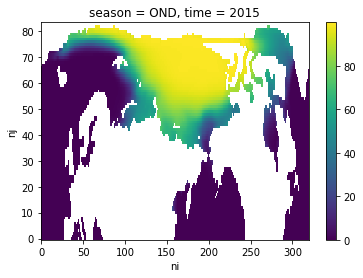

In [45]:
ice_seas_ens_mean_le[0,0,:,:].plot()

## Calculate Linear trend at each point

* Want array like this: slope_rufmod = 4(nseas)x22(nlat)x288(nlon)
* Keep slope, r2, and pvalues --> Use pvalue for stippling

In [46]:
# define some functions from Liz Maroon
# These allow us to do a linear regression at all points

def pvalue_array(x,y,dname):
    x_an=x-x.mean(dname)
    slope=((x_an)*(y-y.mean(dname))).sum(dname)/((x_an)*(x_an)).sum(dname)
    interc=y.mean(dname)-slope*x.mean(dname)
    ypred=slope*x+interc  
    n=len(x[dname])
    mse=np.sqrt(((y-ypred)**2).sum(dname)/(n-2))
    xsq=np.sqrt(((x_an)**2).sum(dname))
    standerr=mse/xsq
    pval=2*(1-t.cdf(np.abs(slope/standerr),n-2))
    pval=xr.DataArray(pval,dims=standerr.dims,coords=standerr.coords)
    return pval

def rvalue_array(x,y,dname):  
    xmean=x.mean(dname)
    ymean=y.mean(dname)
    numer=(x*y).mean(dname)-xmean*ymean
    denom=np.sqrt(((x**2).mean(dname)-xmean**2)*\
                  (((y**2).mean(dname))-(ymean**2)))
    return numer/denom

def regcoeff_array(x,y,dname):
    x_an=x-x.mean(dname)
    y_an=y-y.mean(dname)
    slope=(x_an*y_an).sum(dname)/(x_an*x_an).sum(dname)
    return slope


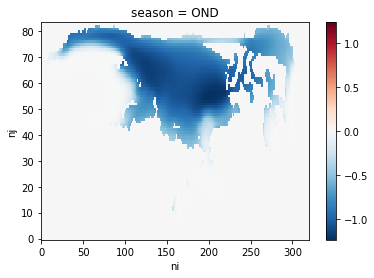

In [47]:
# test this with Liz's functions
tseries = xarr_rufmod
# grab first season only
spatial = ice_seas_ens_mean_rufmod[0,:,:,:]
# set time coordinate arrays to be equal
tseries['time'] = spatial.time
# calculate stats
regcoeff=regcoeff_array(tseries,spatial,'time')
rvalues=rvalue_array(tseries,spatial,'time')
pvalues=pvalue_array(tseries,spatial,'time')
# plot return
regcoeff.plot()

### Trends over entire period: 2020-2100

In [48]:
# Choose initial concentration threshold - 15%
icemin = 15

In [49]:
# Choose entire time period: 2020-2100
ind_st = 5
ind_ed = 85

print(xarr_rufmod[ind_st:ind_ed])


<xarray.DataArray 'year' (time: 80)>
array([2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
       2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
       2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052,
       2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063,
       2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074,
       2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085,
       2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096,
       2097, 2098, 2099])
Coordinates:
  * time     (time) int64 2020 2021 2022 2023 2024 ... 2095 2096 2097 2098 2099
    season   <U3 'OND'


In [50]:
# Loop through seasons - rufmod
print('Calculating Trends - SMOOTH')

# make numpy array to fill and specify dimensions we want
trend_array_rufmod = np.zeros([len(season_names),len(ice_masked_le.nj),len(ice_masked_le.ni)])
sig_array_rufmod = np.zeros([len(season_names),len(ice_masked_le.nj),len(ice_masked_le.ni)])

#for ss in season_names[0:1]:
for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
        
    # grab data we want to regress
    tseries = xarr_rufmod[ind_st:ind_ed]
    spatial = ice_seas_ens_mean_rufmod[s_count,ind_st:ind_ed,:,:]

    # set time coordinate arrays to be equal
    tseries['time'] = spatial.time

    # Calculate rufmod regressions
    regcoeff=10*regcoeff_array(tseries,spatial,'time')
    pvalues=pvalue_array(tseries,spatial,'time')
    
    # Mask the data by points where the ice concentration at the start was below threshold
    regcoeff = regcoeff.where(spatial[0,:,:] > icemin)
    pvalues = pvalues.where(spatial[0,:,:] > icemin)
    
    # Assign arrays to keep
    trend_array_rufmod[s_count,:,:] = regcoeff
    sig_array_rufmod[s_count,:,:] = pvalues

Calculating Trends - SMOOTH
OND
JFM
AMJ
JAS


In [51]:
# Loop through seasons - CESM-LE
print('Calculating Trends - CESM2-LE')

# make numpy array to fill and specify dimensions we want
trend_array_le = np.zeros([len(season_names),len(ice_masked_le.nj),len(ice_masked_le.ni)])
sig_array_le = np.zeros([len(season_names),len(ice_masked_le.nj),len(ice_masked_le.ni)])

for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
        
    # grab data we want to regress
    tseries = xarr_le[ind_st:ind_ed]
    spatial = ice_seas_ens_mean_le[s_count,ind_st:ind_ed,:,:]

    # set time coordinate arrays to be equal
    tseries['time'] = spatial.time

    # Calculate rufmod regressions
    regcoeff=10*regcoeff_array(tseries,spatial,'time')
    pvalues=pvalue_array(tseries,spatial,'time')
    
    # Mask the data by points where the ice concentration at the start was below threshold
    regcoeff = regcoeff.where(spatial[0,:,:] > icemin)
    pvalues = pvalues.where(spatial[0,:,:] > icemin)
    
    # Assign arrays to keep
    trend_array_le[s_count,:,:] = regcoeff
    sig_array_le[s_count,:,:] = pvalues

Calculating Trends - CESM2-LE
OND
JFM
AMJ
JAS


In [52]:
print(trend_array_le.shape)
print(trend_array_rufmod.shape)

(4, 84, 320)
(4, 84, 320)


In [53]:
# convert the numpy array to a xarray for easier plotting
trend_seas_le = xr.DataArray(trend_array_le,dims=('season','nj','ni'))
trend_seas_rufmod = xr.DataArray(trend_array_rufmod,dims=('season','nj','ni'))
sig_seas_le = xr.DataArray(sig_array_le,dims=('season','nj','ni'))
sig_seas_rufmod = xr.DataArray(sig_array_rufmod,dims=('season','nj','ni'))

In [54]:
# set coordinate arrays
trend_seas_le['season'] = season_names
trend_seas_le['nj'] = ice_masked_le['nj'].values
trend_seas_le['ni'] = ice_masked_le['ni'].values

trend_seas_rufmod['season'] = season_names
trend_seas_rufmod['nj'] = ice_masked_rufmod['nj'].values
trend_seas_rufmod['ni'] = ice_masked_rufmod['ni'].values

sig_seas_le['season'] = season_names
sig_seas_le['nj'] = ice_masked_le['nj'].values
sig_seas_le['ni'] = ice_masked_le['ni'].values

sig_seas_rufmod['season'] = season_names
sig_seas_rufmod['nj'] = ice_masked_rufmod['nj'].values
sig_seas_rufmod['ni'] = ice_masked_rufmod['ni'].values

### Trends over first half of period: 2020-2060

In [55]:
# Choose entire time period: 2020-2100
ind_st = 5
ind_ed = 45

print(xarr_rufmod[ind_st:ind_ed])

<xarray.DataArray 'year' (time: 40)>
array([2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
       2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
       2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052,
       2053, 2054, 2055, 2056, 2057, 2058, 2059])
Coordinates:
  * time     (time) int64 2020 2021 2022 2023 2024 ... 2055 2056 2057 2058 2059
    season   <U3 'OND'


In [56]:
# Loop through seasons - rufmod
print('Calculating Trends - SMOOTH')

# make numpy array to fill and specify dimensions we want
trend_array_rufmod = np.zeros([len(season_names),len(ice_masked_le.nj),len(ice_masked_le.ni)])
sig_array_rufmod = np.zeros([len(season_names),len(ice_masked_le.nj),len(ice_masked_le.ni)])

#for ss in season_names[0:1]:
for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
        
    # grab data we want to regress
    tseries = xarr_rufmod[ind_st:ind_ed]
    spatial = ice_seas_ens_mean_rufmod[s_count,ind_st:ind_ed,:,:]

    # set time coordinate arrays to be equal
    tseries['time'] = spatial.time

    # Calculate rufmod regressions
    regcoeff=10*regcoeff_array(tseries,spatial,'time')
    pvalues=pvalue_array(tseries,spatial,'time')
    
    # Mask the data by points where the ice concentration at the start was below threshold
    regcoeff = regcoeff.where(spatial[0,:,:] > icemin)
    pvalues = pvalues.where(spatial[0,:,:] > icemin)
    
    # Assign arrays to keep
    trend_array_rufmod[s_count,:,:] = regcoeff
    sig_array_rufmod[s_count,:,:] = pvalues

Calculating Trends - SMOOTH
OND
JFM
AMJ
JAS


In [57]:
# Loop through seasons - CESM-LE
print('Calculating Trends - CESM2-LE')

# make numpy array to fill and specify dimensions we want
trend_array_le = np.zeros([len(season_names),len(ice_masked_le.nj),len(ice_masked_le.ni)])
sig_array_le = np.zeros([len(season_names),len(ice_masked_le.nj),len(ice_masked_le.ni)])

for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
        
    # grab data we want to regress
    tseries = xarr_le[ind_st:ind_ed]
    spatial = ice_seas_ens_mean_le[s_count,ind_st:ind_ed,:,:]

    # set time coordinate arrays to be equal
    tseries['time'] = spatial.time

    # Calculate rufmod regressions
    regcoeff=10*regcoeff_array(tseries,spatial,'time')
    pvalues=pvalue_array(tseries,spatial,'time')
    
    # Mask the data by points where the ice concentration at the start was below threshold
    regcoeff = regcoeff.where(spatial[0,:,:] > icemin)
    pvalues = pvalues.where(spatial[0,:,:] > icemin)
    
    # Assign arrays to keep
    trend_array_le[s_count,:,:] = regcoeff
    sig_array_le[s_count,:,:] = pvalues

Calculating Trends - CESM2-LE
OND
JFM
AMJ
JAS


In [58]:
print(trend_array_le.shape)
print(trend_array_rufmod.shape)

(4, 84, 320)
(4, 84, 320)


In [59]:
# convert the numpy array to a xarray for easier plotting
trend_seas_first_40_le = xr.DataArray(trend_array_le,dims=('season','nj','ni'))
trend_seas_first_40_rufmod = xr.DataArray(trend_array_rufmod,dims=('season','nj','ni'))
sig_seas_first_40_le = xr.DataArray(sig_array_le,dims=('season','nj','ni'))
sig_seas_first_40_rufmod = xr.DataArray(sig_array_rufmod,dims=('season','nj','ni'))

In [60]:
# set coordinate arrays
trend_seas_first_40_le['season'] = season_names
trend_seas_first_40_le['nj'] = ice_masked_le['nj'].values
trend_seas_first_40_le['ni'] = ice_masked_le['ni'].values

trend_seas_first_40_rufmod['season'] = season_names
trend_seas_first_40_rufmod['nj'] = ice_masked_rufmod['nj'].values
trend_seas_first_40_rufmod['ni'] = ice_masked_rufmod['ni'].values

sig_seas_first_40_le['season'] = season_names
sig_seas_first_40_le['nj'] = ice_masked_le['nj'].values
sig_seas_first_40_le['ni'] = ice_masked_le['ni'].values

sig_seas_first_40_rufmod['season'] = season_names
sig_seas_first_40_rufmod['nj'] = ice_masked_rufmod['nj'].values
sig_seas_first_40_rufmod['ni'] = ice_masked_rufmod['ni'].values

### Trends over second half of period: 2060-2100

In [61]:
# Choose entire time period: 2020-2100
ind_st = 45
ind_ed = 85

print(xarr_rufmod[ind_st:ind_ed])

<xarray.DataArray 'year' (time: 40)>
array([2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070,
       2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081,
       2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092,
       2093, 2094, 2095, 2096, 2097, 2098, 2099])
Coordinates:
  * time     (time) int64 2060 2061 2062 2063 2064 ... 2095 2096 2097 2098 2099
    season   <U3 'OND'


In [62]:
# Loop through seasons - rufmod
print('Calculating Trends - SMOOTH')

# make numpy array to fill and specify dimensions we want
trend_array_rufmod = np.zeros([len(season_names),len(ice_masked_le.nj),len(ice_masked_le.ni)])
sig_array_rufmod = np.zeros([len(season_names),len(ice_masked_le.nj),len(ice_masked_le.ni)])

#for ss in season_names[0:1]:
for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
        
    # grab data we want to regress
    tseries = xarr_rufmod[ind_st:ind_ed]
    spatial = ice_seas_ens_mean_rufmod[s_count,ind_st:ind_ed,:,:]

    # set time coordinate arrays to be equal
    tseries['time'] = spatial.time

    # Calculate rufmod regressions
    regcoeff=10*regcoeff_array(tseries,spatial,'time')
    pvalues=pvalue_array(tseries,spatial,'time')
    
    # Mask the data by points where the ice concentration at the start was below threshold
    regcoeff = regcoeff.where(spatial[0,:,:] > icemin)
    pvalues = pvalues.where(spatial[0,:,:] > icemin)
    
    # Assign arrays to keep
    trend_array_rufmod[s_count,:,:] = regcoeff
    sig_array_rufmod[s_count,:,:] = pvalues

Calculating Trends - SMOOTH
OND
JFM
AMJ
JAS


In [63]:
# Loop through seasons - CESM-LE
print('Calculating Trends - CESM2-LE')

# make numpy array to fill and specify dimensions we want
trend_array_le = np.zeros([len(season_names),len(ice_masked_le.nj),len(ice_masked_le.ni)])
sig_array_le = np.zeros([len(season_names),len(ice_masked_le.nj),len(ice_masked_le.ni)])

for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
        
    # grab data we want to regress
    tseries = xarr_le[ind_st:ind_ed]
    spatial = ice_seas_ens_mean_le[s_count,ind_st:ind_ed,:,:]

    # set time coordinate arrays to be equal
    tseries['time'] = spatial.time

    # Calculate rufmod regressions
    regcoeff=10*regcoeff_array(tseries,spatial,'time')
    pvalues=pvalue_array(tseries,spatial,'time')
    
    # Mask the data by points where the ice concentration at the start was below threshold
    regcoeff = regcoeff.where(spatial[0,:,:] > icemin)
    pvalues = pvalues.where(spatial[0,:,:] > icemin)
    
    # Assign arrays to keep
    trend_array_le[s_count,:,:] = regcoeff
    sig_array_le[s_count,:,:] = pvalues

Calculating Trends - CESM2-LE
OND
JFM
AMJ
JAS


In [64]:
print(trend_array_le.shape)
print(trend_array_rufmod.shape)

(4, 84, 320)
(4, 84, 320)


In [65]:
# convert the numpy array to a xarray for easier plotting
trend_seas_last_40_le = xr.DataArray(trend_array_le,dims=('season','nj','ni'))
trend_seas_last_40_rufmod = xr.DataArray(trend_array_rufmod,dims=('season','nj','ni'))
sig_seas_last_40_le = xr.DataArray(sig_array_le,dims=('season','nj','ni'))
sig_seas_last_40_rufmod = xr.DataArray(sig_array_rufmod,dims=('season','nj','ni'))

In [66]:
# set coordinate arrays
trend_seas_last_40_le['season'] = season_names
trend_seas_last_40_le['nj'] = ice_masked_le['nj'].values
trend_seas_last_40_le['ni'] = ice_masked_le['ni'].values

trend_seas_last_40_rufmod['season'] = season_names
trend_seas_last_40_rufmod['nj'] = ice_masked_rufmod['nj'].values
trend_seas_last_40_rufmod['ni'] = ice_masked_rufmod['ni'].values

sig_seas_last_40_le['season'] = season_names
sig_seas_last_40_le['nj'] = ice_masked_le['nj'].values
sig_seas_last_40_le['ni'] = ice_masked_le['ni'].values

sig_seas_last_40_rufmod['season'] = season_names
sig_seas_last_40_rufmod['nj'] = ice_masked_rufmod['nj'].values
sig_seas_last_40_rufmod['ni'] = ice_masked_rufmod['ni'].values

## Set a mask for region of interest

In [67]:
# Load in masks
mask_in = ['nh_mask', 'Lab_mask', 'GIN_mask', 'Bar_mask', 'ArcOc_mask', 'Sib_mask', 'Beau_mask', 'Bering_mask', 'Hudson_mask', 'CAArch_mask', 'Okhotsk_mask']

ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/masks/REGION_MASK_gx1v7.nc')
ds_masks=ds_masks.rename({'lat':'nj','lon': 'ni'})
my_mask = ds_masks[mask_in].isel(time=0)

# now load in the different masks as a new coordinate
masks=xr.concat([my_mask.nh_mask,my_mask.Lab_mask,my_mask.GIN_mask,my_mask.Bar_mask,my_mask.ArcOc_mask,my_mask.Sib_mask,my_mask.Beau_mask,my_mask.Bering_mask,my_mask.Hudson_mask,my_mask.CAArch_mask,my_mask.Okhotsk_mask],dim='region')
masks['region']=mask_in

/glade/work/duvivier/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Lab_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'GIN_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Bar_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'ArcOc_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade

In [68]:
#mask just NH points
masks = masks.isel(nj=slice(300,384))

In [69]:
# read in two relevant masks
reg1 = 'ArcOc_mask'
reg2 = 'Bar_mask'
reg = reg1+'_and_'+reg2
mask_both = masks.sel(region=reg1).fillna(0) + masks.sel(region=reg2).fillna(0)
mask_both = mask_both.where(mask_both == 1)

## Mask the data by central Arctic only

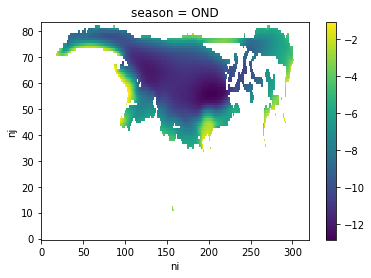

In [70]:
trend_seas_le.sel(season='OND').plot()

In [71]:
# mask everything but the central Arctic
trend_seas_le_CA = trend_seas_le.where(mask_both ==1)
trend_seas_rufmod_CA = trend_seas_rufmod.where(mask_both==1)
sig_seas_le_CA = sig_seas_le.where(mask_both ==1)
sig_seas_rufmod_CA = sig_seas_rufmod.where(mask_both ==1)

trend_seas_first_40_le_CA = trend_seas_first_40_le.where(mask_both ==1)
trend_seas_first_40_rufmod_CA = trend_seas_first_40_rufmod.where(mask_both==1)
sig_seas_first_40_le_CA = sig_seas_first_40_le.where(mask_both ==1)
sig_seas_first_40_rufmod_CA = sig_seas_first_40_rufmod.where(mask_both ==1)

trend_seas_last_40_le_CA = trend_seas_last_40_le.where(mask_both ==1)
trend_seas_last_40_rufmod_CA = trend_seas_last_40_rufmod.where(mask_both==1)
sig_seas_last_40_le_CA = sig_seas_last_40_le.where(mask_both ==1)
sig_seas_last_40_rufmod_CA = sig_seas_last_40_rufmod.where(mask_both ==1)


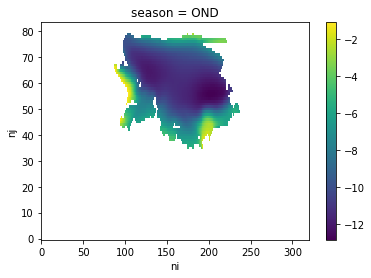

In [72]:
trend_seas_le_CA.sel(season='OND').plot()

## Plotting

### General plotting data

In [73]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [74]:
# get pop grid for lat/lon values
grid = pop_tools.get_grid('POP_gx1v7')
# assign lat/lon data
TLONG = grid.TLONG
TLAT = grid.TLAT

In [75]:
# Keep only NH points
TLONG_sub = TLONG.isel(nlat=slice(300,384))
TLAT_sub = TLAT.isel(nlat=slice(300,384))

### Regrid so we can plot contours properly

In [76]:
trend_seas_le_CA

<xarray.DataArray (season: 4, nj: 84, ni: 320)>
dask.array<where, shape=(4, 84, 320), dtype=float64, chunksize=(4, 84, 320), chunktype=numpy.ndarray>
Coordinates:
  * nj       (nj) int64 0 1 2 3 4 5 6 7 8 9 10 ... 74 75 76 77 78 79 80 81 82 83
  * ni       (ni) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * season   (season) <U3 'OND' 'JFM' 'AMJ' 'JAS'

In [77]:
TLONG_sub

<xarray.DataArray 'TLONG' (nlat: 84, nlon: 320)>
array([[320.55042684, 321.6512494 , 322.75208104, ..., 317.24793677,
        318.34876841, 319.44960077],
       [320.54988642, 321.64962814, 322.74937889, ..., 317.25063892,
        318.35038967, 319.45014118],
       [320.5493265 , 321.64794838, 322.74657922, ..., 317.25343859,
        318.35206943, 319.45070109],
       ...,
       [320.25133086, 320.75380113, 321.25577325, ..., 318.74424456,
        319.24621668, 319.74869143],
       [320.23459477, 320.70358949, 321.17207442, ..., 318.82794339,
        319.29642832, 319.76542721],
       [320.21650899, 320.6493303 , 321.08163473, ..., 318.91838308,
        319.3506875 , 319.78351267]])
Dimensions without coordinates: nlat, nlon
Attributes:
    units:      degrees_east
    long_name:  T-grid longitude

In [78]:
# rename lat and lon coordinates
TLAT_sub = TLAT_sub.rename({'nlon':'ni','nlat':'nj'})
TLONG_sub = TLONG_sub.rename({'nlon':'ni','nlat':'nj'})

In [79]:
# Set the lon and lat fields to be the POP lats and lons
# if there are no variables in the dataset named 'TLON' and 'TLAT' already they will now be created
trend_seas_le_CA['TLON']=TLONG_sub
trend_seas_le_CA['TLAT']=TLAT_sub

trend_seas_rufmod_CA['TLON']=TLONG_sub
trend_seas_rufmod_CA['TLAT']=TLAT_sub

sig_seas_le_CA['TLON']=TLONG_sub
sig_seas_le_CA['TLAT']=TLAT_sub

sig_seas_rufmod_CA['TLON']=TLONG_sub
sig_seas_rufmod_CA['TLAT']=TLAT_sub


trend_seas_first_40_le_CA['TLON']=TLONG_sub
trend_seas_first_40_le_CA['TLAT']=TLAT_sub

trend_seas_first_40_rufmod_CA['TLON']=TLONG_sub
trend_seas_first_40_rufmod_CA['TLAT']=TLAT_sub

sig_seas_first_40_le_CA['TLON']=TLONG_sub
sig_seas_first_40_le_CA['TLAT']=TLAT_sub

sig_seas_first_40_rufmod_CA['TLON']=TLONG_sub
sig_seas_first_40_rufmod_CA['TLAT']=TLAT_sub


trend_seas_last_40_le_CA['TLON']=TLONG_sub
trend_seas_last_40_le_CA['TLAT']=TLAT_sub

trend_seas_last_40_rufmod_CA['TLON']=TLONG_sub
trend_seas_last_40_rufmod_CA['TLAT']=TLAT_sub

sig_seas_last_40_le_CA['TLON']=TLONG_sub
sig_seas_last_40_le_CA['TLAT']=TLAT_sub

sig_seas_last_40_rufmod_CA['TLON']=TLONG_sub
sig_seas_last_40_rufmod_CA['TLAT']=TLAT_sub

In [80]:
trend_seas_le_CA

<xarray.DataArray (season: 4, nj: 84, ni: 320)>
dask.array<where, shape=(4, 84, 320), dtype=float64, chunksize=(4, 84, 320), chunktype=numpy.ndarray>
Coordinates:
  * nj       (nj) int64 0 1 2 3 4 5 6 7 8 9 10 ... 74 75 76 77 78 79 80 81 82 83
  * ni       (ni) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * season   (season) <U3 'OND' 'JFM' 'AMJ' 'JAS'
    TLON     (nj, ni) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nj, ni) float64 39.14 39.14 39.14 39.15 ... 72.21 72.2 72.19 72.19

In [81]:
#Now rename TLON and TLAT to be lon and lat
trend_seas_le_CA=trend_seas_le_CA.rename({'TLON':'lon','TLAT':'lat'})
trend_seas_rufmod_CA=trend_seas_rufmod_CA.rename({'TLON':'lon','TLAT':'lat'})
sig_seas_le_CA=sig_seas_le_CA.rename({'TLON':'lon','TLAT':'lat'})
sig_seas_rufmod_CA=sig_seas_rufmod_CA.rename({'TLON':'lon','TLAT':'lat'})

trend_seas_first_40_le_CA=trend_seas_first_40_le_CA.rename({'TLON':'lon','TLAT':'lat'})
trend_seas_first_40_rufmod_CA=trend_seas_first_40_rufmod_CA.rename({'TLON':'lon','TLAT':'lat'})
sig_seas_first_40_le_CA=sig_seas_first_40_le_CA.rename({'TLON':'lon','TLAT':'lat'})
sig_seas_first_40_rufmod_CA=sig_seas_first_40_rufmod_CA.rename({'TLON':'lon','TLAT':'lat'})

trend_seas_last_40_le_CA=trend_seas_last_40_le_CA.rename({'TLON':'lon','TLAT':'lat'})
trend_seas_last_40_rufmod_CA=trend_seas_last_40_rufmod_CA.rename({'TLON':'lon','TLAT':'lat'})
sig_seas_last_40_le_CA=sig_seas_last_40_le_CA.rename({'TLON':'lon','TLAT':'lat'})
sig_seas_last_40_rufmod_CA=sig_seas_last_40_rufmod_CA.rename({'TLON':'lon','TLAT':'lat'})


In [82]:
trend_seas_le_CA

<xarray.DataArray (season: 4, nj: 84, ni: 320)>
dask.array<where, shape=(4, 84, 320), dtype=float64, chunksize=(4, 84, 320), chunktype=numpy.ndarray>
Coordinates:
  * nj       (nj) int64 0 1 2 3 4 5 6 7 8 9 10 ... 74 75 76 77 78 79 80 81 82 83
  * ni       (ni) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * season   (season) <U3 'OND' 'JFM' 'AMJ' 'JAS'
    lon      (nj, ni) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    lat      (nj, ni) float64 39.14 39.14 39.14 39.15 ... 72.21 72.2 72.19 72.19

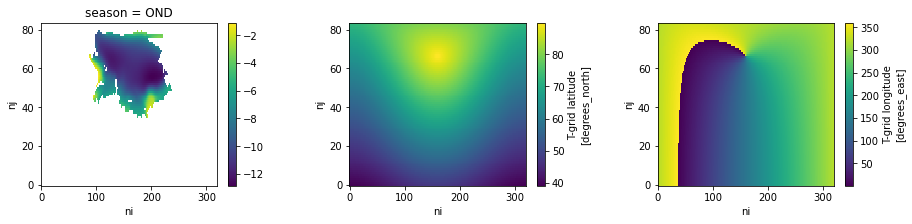

In [83]:
fig,ax=plt.subplots(1,3,figsize=(15,3))
axs=ax.flatten()
trend_seas_le_CA.sel(season='OND').plot(ax=axs[0])
TLAT_sub.plot(ax=axs[1])
TLONG_sub.plot(ax=axs[2])
plt.subplots_adjust(wspace=0.4)

In [84]:
# Setting up a target grid to only regrid data in the northern hemisphere north of ~50N
#Start at ~50N, but do not include 90N otherwise cartopy gets rage-y (i.e. it doesn't work) when plotting
lat=np.arange(49.4,90.0,0.5) 
lon=np.arange(0.0,361.0,1.0)
#create a meshgrid (2D fields of lats and lons)
lon2d,lat2d=np.meshgrid(lon,lat) 
#set up the target grid as an xarray Dataset
target_grid=xr.Dataset({'lat': (['y', 'x'], lat2d),'lon': (['y', 'x'], lon2d)})

In [85]:
#input grid, output grid, method, keyword arguments
regridder=xe.Regridder(trend_seas_le_CA, target_grid, 'nearest_s2d',periodic=True,reuse_weights=False)

/glade/work/duvivier/miniconda3/envs/analysis2/lib/python3.7/site-packages/dask/array/core.py:405: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


In [86]:
# actually do the regridding
trend_seas_le_CA_regrid=regridder(trend_seas_le_CA)
trend_seas_rufmod_CA_regrid=regridder(trend_seas_rufmod_CA)
sig_seas_le_CA_regrid=regridder(sig_seas_le_CA)
sig_seas_rufmod_CA_regrid=regridder(sig_seas_rufmod_CA)

trend_seas_first_40_le_CA_regrid=regridder(trend_seas_first_40_le_CA)
trend_seas_first_40_rufmod_CA_regrid=regridder(trend_seas_first_40_rufmod_CA)
sig_seas_first_40_le_CA_regrid=regridder(sig_seas_first_40_le_CA)
sig_seas_first_40_rufmod_CA_regrid=regridder(sig_seas_first_40_rufmod_CA)

trend_seas_last_40_le_CA_regrid=regridder(trend_seas_last_40_le_CA)
trend_seas_last_40_rufmod_CA_regrid=regridder(trend_seas_last_40_rufmod_CA)
sig_seas_last_40_le_CA_regrid=regridder(sig_seas_last_40_le_CA)
sig_seas_last_40_rufmod_CA_regrid=regridder(sig_seas_last_40_rufmod_CA)


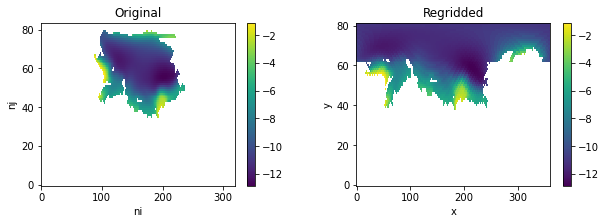

In [87]:
fig,ax=plt.subplots(1,2,figsize=(10,3))
axs=ax.flatten()
trend_seas_le_CA.sel(season='OND').plot(ax=axs[0])
axs[0].set_title('Original')
trend_seas_le_CA_regrid.sel(season='OND').plot(ax=axs[1])
axs[1].set_title('Regridded')
plt.subplots_adjust(wspace=0.3)

### Now Plot - spatial plots by season of the trends at each point and difference.

Plotting regressions for OND
Plotting regressions for JFM
Plotting regressions for AMJ
Plotting regressions for JAS


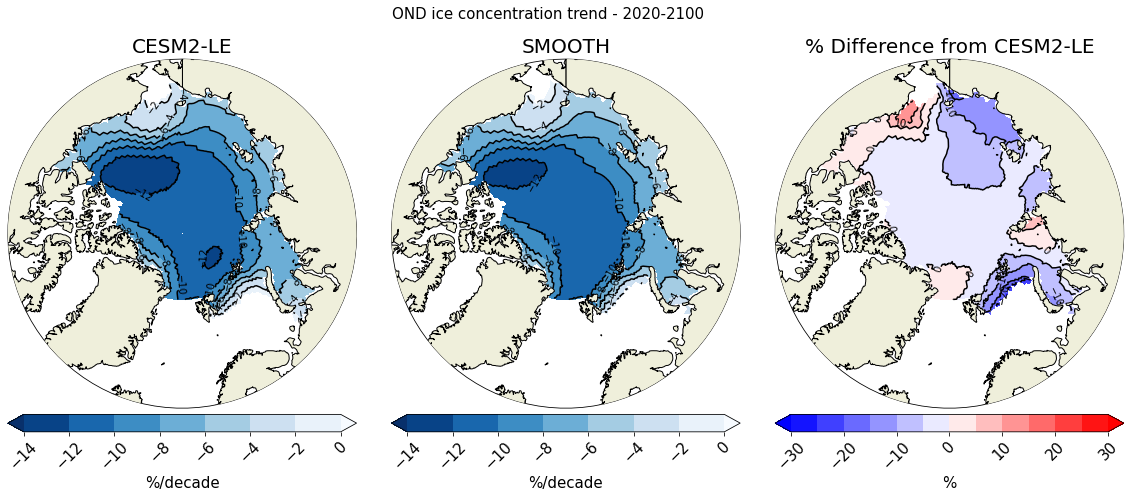

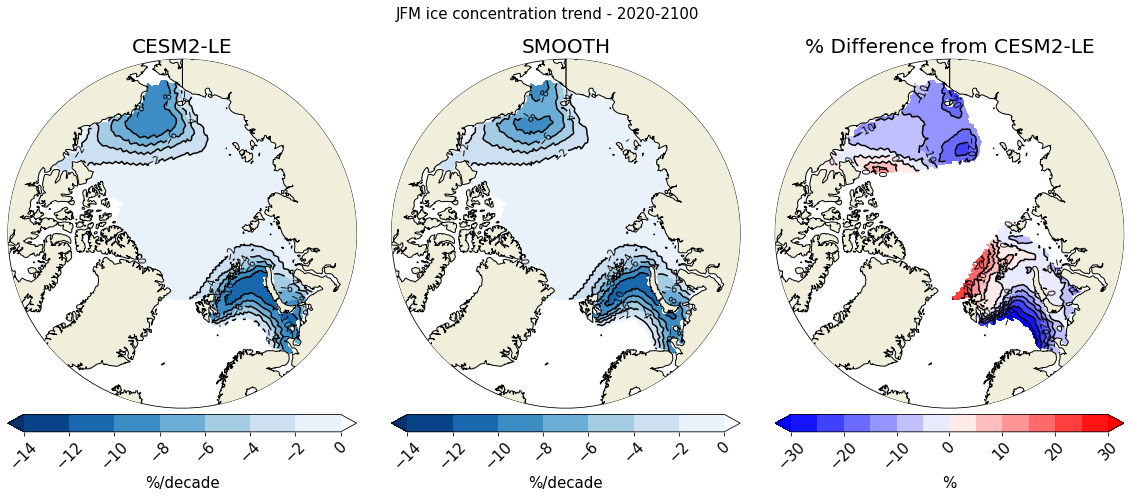

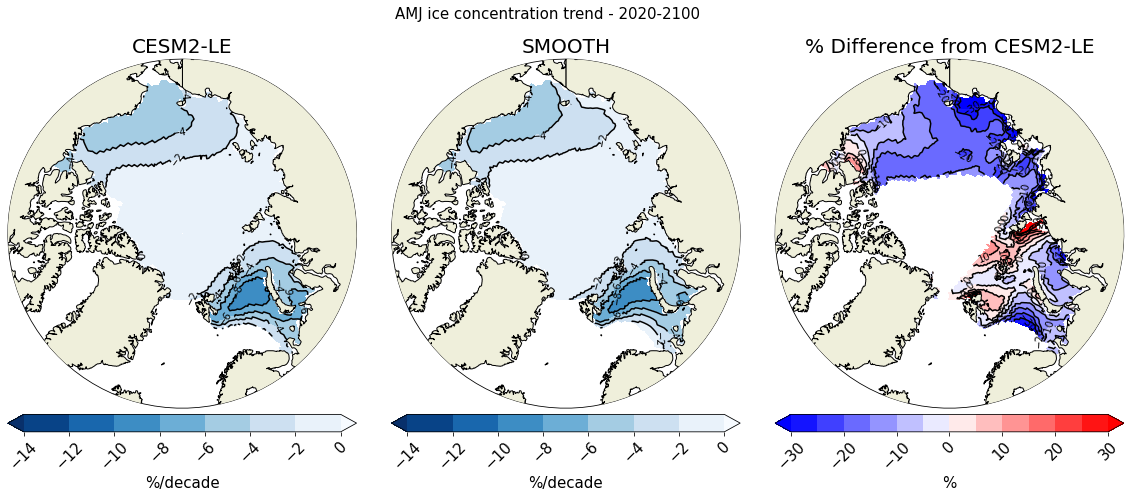

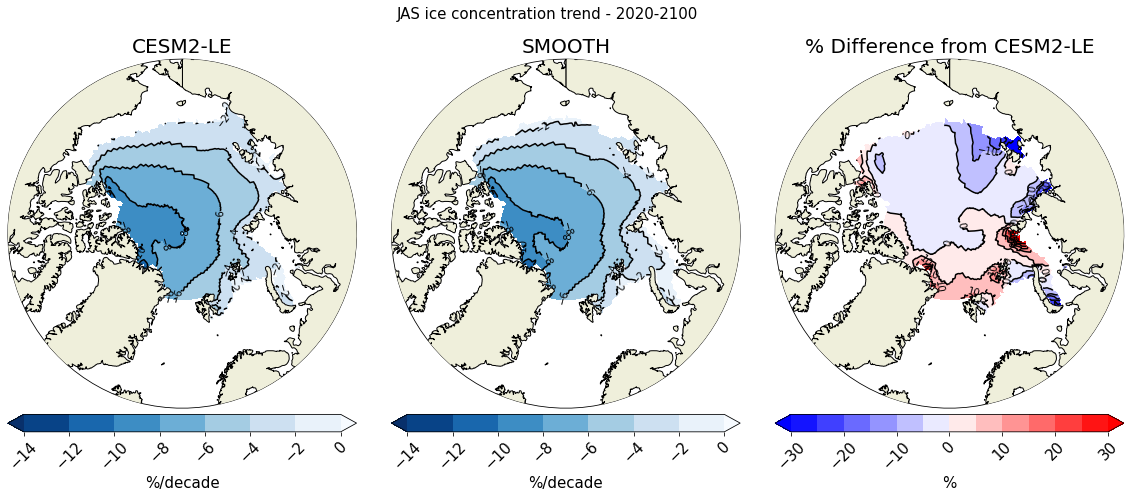

In [88]:
# set units
units = '%'
# set significance level (0.05 --> 95%; 0.01 --> 99%)
sigval = 0.05

#Plot each season and percent difference
levels_in = np.arange(-14,2,2)
cmap_in = plt.cm.get_cmap('Blues')
cmap_in = cmap_in.reversed()
levels_diff = np.arange(-30,35,5)
cmap_diff = plt.cm.get_cmap('bwr')

#for ss in season_names[0:1]:
for ss in season_names:
    print('Plotting regressions for '+ss)
    # grab data to plot
    temp_trend_le = trend_seas_le_CA_regrid.sel(season=ss)
    temp_trend_rufmod = trend_seas_rufmod_CA_regrid.sel(season=ss)
    temp_sig_le = sig_seas_le_CA_regrid.sel(season=ss)
    temp_sig_rufmod = sig_seas_rufmod_CA_regrid.sel(season=ss)

    # mask trends by significant values
    temp_trend_le_masked = temp_trend_le.where(temp_sig_le < sigval)
    temp_trend_rufmod_masked = temp_trend_rufmod.where(temp_sig_rufmod < sigval)    
    # also mask where trends are less than 1% per decade
    temp_trend_le_masked = temp_trend_le_masked.where(abs(temp_trend_le_masked) > 1.0)
    temp_trend_rufmod_masked = temp_trend_rufmod_masked.where(abs(temp_trend_rufmod_masked) > 1.0)
    
    # calculate % difference
    diff = 100*((temp_trend_rufmod_masked - temp_trend_le_masked)/temp_trend_le_masked)
           
    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = 'cesm2_le_and_rufmod_'+var_in_1+'_trends_pcnt_diff_2020_2100_'+ss
    title = ss+' ice concentration trend - 2020-2100'
     
    # Make subplots - note it's nrow x ncol x index (starting upper left)
    ### First subplot: CESM2-LE
    ax = fig.add_subplot(1,3,1, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    # plot this month's trends
    this=ax.contourf(temp_trend_le.lon,temp_trend_le.lat,
                     temp_trend_le,
                     cmap = cmap_in,                      
                     levels=levels_in,extend='both',
                     transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(temp_trend_le.lon,temp_trend_le.lat,
                     temp_trend_le,
                     colors='black',linestyles='solid',levels=levels_in,
                     transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # add significance overlay
    sig = ax.pcolor(temp_sig_le.lon,temp_sig_rufmod.lat,
                    temp_sig_le.where(temp_sig_le > sigval),
                    alpha=0, hatch='xx',
                    transform=ccrs.PlateCarree()) 
    # add colorbar
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units+'/decade', fontsize=15)
    plt.title('CESM2-LE',fontsize=20)
    
    ### Second subplot: CESM2-LE
    ax = fig.add_subplot(1,3,2, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(temp_trend_rufmod.lon,temp_trend_rufmod.lat,
                     temp_trend_rufmod,
                     cmap = cmap_in,                      
                     levels=levels_in,extend='both',
                     transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(temp_trend_rufmod.lon,temp_trend_rufmod.lat,
                     temp_trend_rufmod,
                     colors='black',linestyles='solid',levels=levels_in,
                    transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # add significance overlay
    sig = ax.pcolor(temp_sig_rufmod.lon,temp_sig_rufmod.lat,
                    temp_sig_rufmod.where(temp_sig_rufmod > sigval),
                    alpha=0, hatch='xx',
                    transform=ccrs.PlateCarree()) 
    # add colorbar 
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units+'/decade', fontsize=15)
    plt.title('SMOOTH',fontsize=20)

    # Third subplot: Diff
    ax = fig.add_subplot(1,3,3, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    # plot % diffs
    this=ax.contourf(diff.lon,diff.lat,
                     diff,
                     cmap = cmap_diff,                      
                     levels=levels_diff, extend='both',
                     transform=ccrs.PlateCarree()) 
    # add contour lines and labels
    this2=ax.contour(diff.lon,diff.lat,
                     diff,
                     colors='black',linestyles='solid',levels=levels_diff,
                     transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels[::2], inline=True, fontsize=10, colors='black')
    # add colorbar
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel('%', fontsize=15)
    plt.title('% Difference from CESM2-LE',fontsize=20)
    
    # Finalize figure and save
    fig.suptitle(title,fontsize=15, y=0.75)  
    fig.subplots_adjust(bottom=0.45,wspace=0.1)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)  


Plotting regressions for OND
Plotting regressions for JFM
Plotting regressions for AMJ
Plotting regressions for JAS


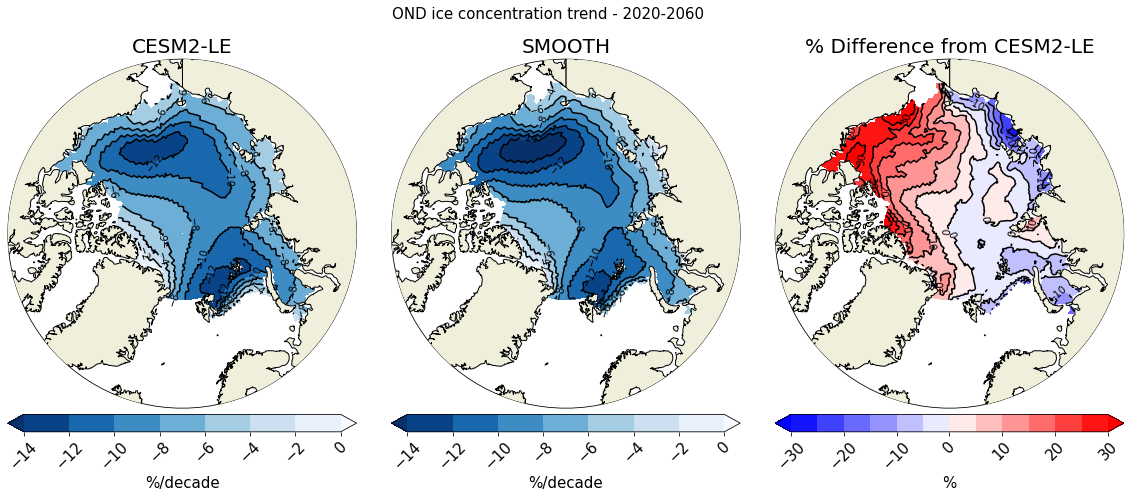

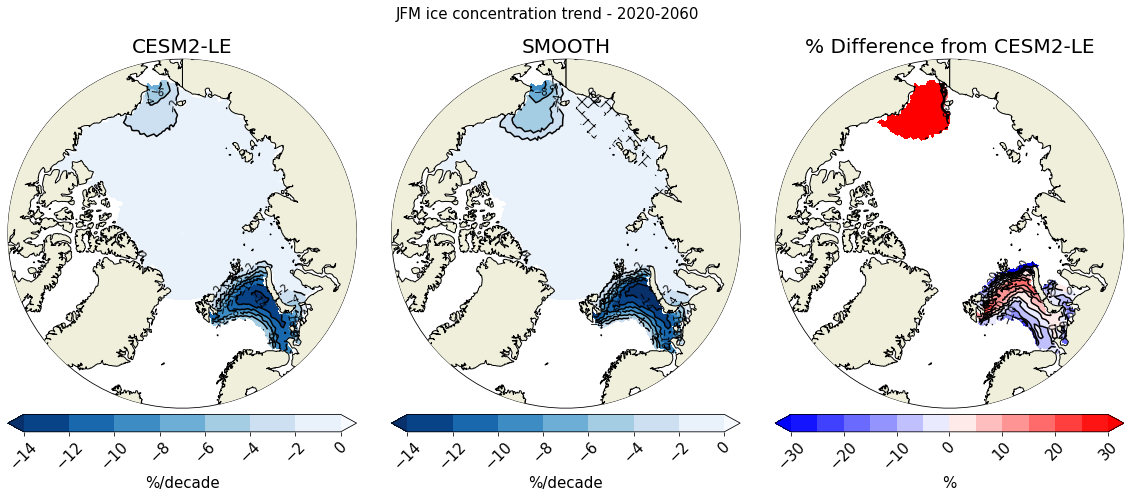

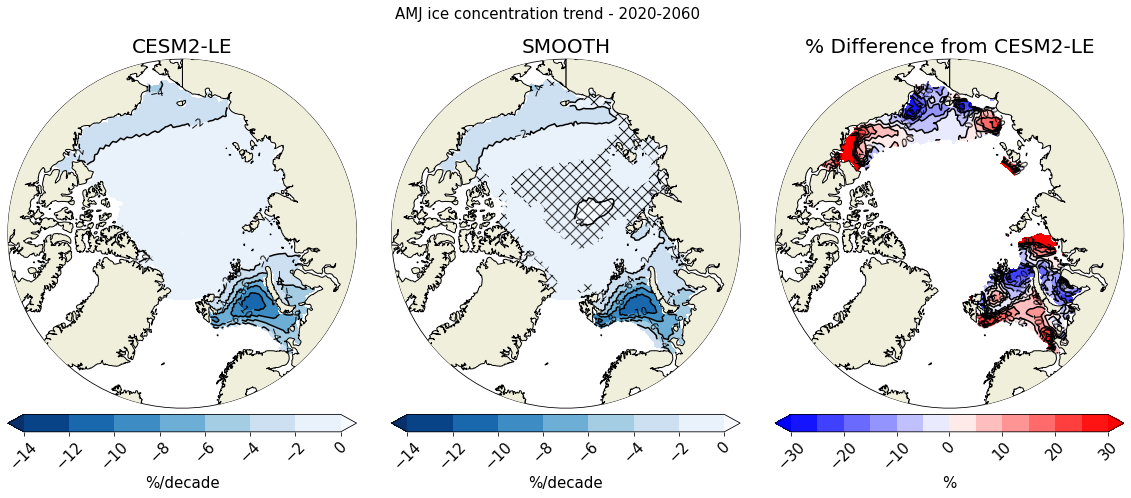

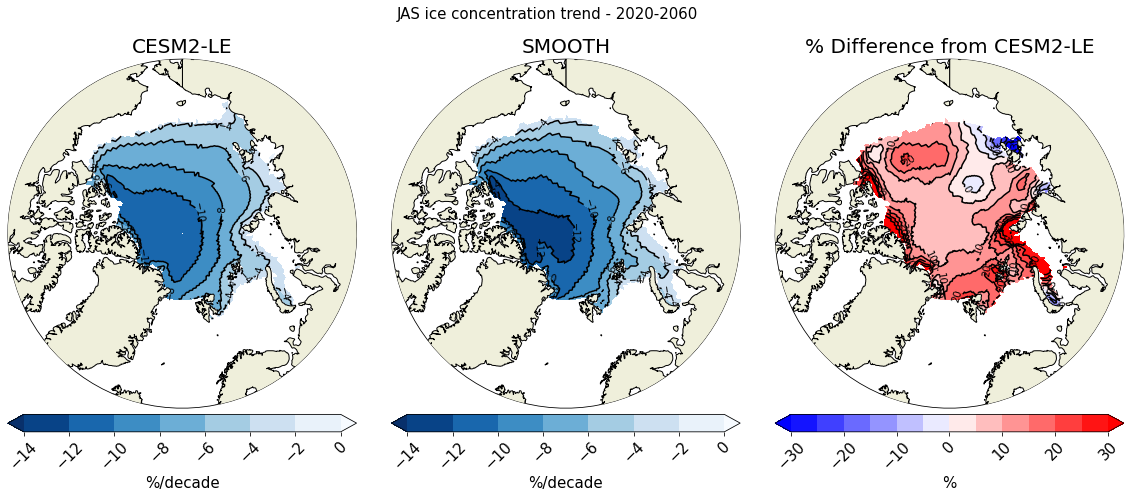

In [91]:
# set units
units = '%'
# set significance level (0.05 --> 95%; 0.01 --> 99%)
sigval = 0.05

#Plot each season and percent difference
levels_in = np.arange(-14,2,2)
cmap_in = plt.cm.get_cmap('Blues')
cmap_in = cmap_in.reversed()
levels_diff = np.arange(-30,35,5)
cmap_diff = plt.cm.get_cmap('bwr')

#for ss in season_names[0:1]:
for ss in season_names:
    print('Plotting regressions for '+ss)
    # grab data to plot
    temp_trend_le = trend_seas_first_40_le_CA_regrid.sel(season=ss)
    temp_trend_rufmod = trend_seas_first_40_rufmod_CA_regrid.sel(season=ss)
    temp_sig_le = sig_seas_first_40_le_CA_regrid.sel(season=ss)
    temp_sig_rufmod = sig_seas_first_40_rufmod_CA_regrid.sel(season=ss)

    # mask trends by significant values
    temp_trend_le_masked = temp_trend_le.where(temp_sig_le < sigval)
    temp_trend_rufmod_masked = temp_trend_rufmod.where(temp_sig_rufmod < sigval)    
    # also mask where trends are less than 1% per decade
    temp_trend_le_masked = temp_trend_le_masked.where(abs(temp_trend_le_masked) > 1.0)
    temp_trend_rufmod_masked = temp_trend_rufmod_masked.where(abs(temp_trend_rufmod_masked) > 1.0)
    
    # calculate % difference
    diff = 100*((temp_trend_rufmod_masked - temp_trend_le_masked)/temp_trend_le_masked)
           
    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = 'cesm2_le_and_rufmod_'+var_in_1+'_trends_pcnt_diff_2020_2060_'+ss
    title = ss+' ice concentration trend - 2020-2060'
     
    # Make subplots - note it's nrow x ncol x index (starting upper left)
    ### First subplot: CESM2-LE
    ax = fig.add_subplot(1,3,1, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    # plot this month's trends
    this=ax.contourf(temp_trend_le.lon,temp_trend_le.lat,
                     temp_trend_le,
                     cmap = cmap_in,                      
                     levels=levels_in,extend='both',
                     transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(temp_trend_le.lon,temp_trend_le.lat,
                     temp_trend_le,
                     colors='black',linestyles='solid',levels=levels_in,
                     transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # add significance overlay
    sig = ax.pcolor(temp_sig_le.lon,temp_sig_rufmod.lat,
                    temp_sig_le.where(temp_sig_le > sigval),
                    alpha=0, hatch='xx',
                    transform=ccrs.PlateCarree()) 
    # add colorbar
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units+'/decade', fontsize=15)
    plt.title('CESM2-LE',fontsize=20)
    
    ### Second subplot: CESM2-LE
    ax = fig.add_subplot(1,3,2, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(temp_trend_rufmod.lon,temp_trend_rufmod.lat,
                     temp_trend_rufmod,
                     cmap = cmap_in,                      
                     levels=levels_in,extend='both',
                     transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(temp_trend_rufmod.lon,temp_trend_rufmod.lat,
                     temp_trend_rufmod,
                     colors='black',linestyles='solid',levels=levels_in,
                    transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # add significance overlay
    sig = ax.pcolor(temp_sig_rufmod.lon,temp_sig_rufmod.lat,
                    temp_sig_rufmod.where(temp_sig_rufmod > sigval),
                    alpha=0, hatch='xx',
                    transform=ccrs.PlateCarree()) 
    # add colorbar 
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units+'/decade', fontsize=15)
    plt.title('SMOOTH',fontsize=20)

    # Third subplot: Diff
    ax = fig.add_subplot(1,3,3, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    # plot % diffs
    this=ax.contourf(diff.lon,diff.lat,
                     diff,
                     cmap = cmap_diff,                      
                     levels=levels_diff, extend='both',
                     transform=ccrs.PlateCarree()) 
    # add contour lines and labels
    this2=ax.contour(diff.lon,diff.lat,
                     diff,
                     colors='black',linestyles='solid',levels=levels_diff,
                     transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels[::2], inline=True, fontsize=10, colors='black')
    # add colorbar
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel('%', fontsize=15)
    plt.title('% Difference from CESM2-LE',fontsize=20)
    
    # Finalize figure and save
    fig.suptitle(title,fontsize=15, y=0.75)  
    fig.subplots_adjust(bottom=0.45,wspace=0.1)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)  


In [ ]:
# set units
units = '%'
# set significance level (0.05 --> 95%; 0.01 --> 99%)
sigval = 0.05

#Plot each season and percent difference
levels_in = np.arange(-14,2,2)
cmap_in = plt.cm.get_cmap('Blues')
cmap_in = cmap_in.reversed()
levels_diff = np.arange(-30,35,5)
cmap_diff = plt.cm.get_cmap('bwr')

#for ss in season_names[0:1]:
for ss in season_names:
    print('Plotting regressions for '+ss)
    # grab data to plot
    temp_trend_le = trend_seas_last_40_le_CA_regrid.sel(season=ss)
    temp_trend_rufmod = trend_seas_last_40_rufmod_CA_regrid.sel(season=ss)
    temp_sig_le = sig_seas_last_40_le_CA_regrid.sel(season=ss)
    temp_sig_rufmod = sig_seas_last_40_rufmod_CA_regrid.sel(season=ss)

    # mask trends by significant values
    temp_trend_le_masked = temp_trend_le.where(temp_sig_le < sigval)
    temp_trend_rufmod_masked = temp_trend_rufmod.where(temp_sig_rufmod < sigval)    
    # also mask where trends are less than 1% per decade
    temp_trend_le_masked = temp_trend_le_masked.where(abs(temp_trend_le_masked) > 1.0)
    temp_trend_rufmod_masked = temp_trend_rufmod_masked.where(abs(temp_trend_rufmod_masked) > 1.0)
    
    # calculate % difference
    diff = 100*((temp_trend_rufmod_masked - temp_trend_le_masked)/temp_trend_le_masked)
           
    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = 'cesm2_le_and_rufmod_'+var_in_1+'_trends_pcnt_diff_2060_2100_'+ss
    title = ss+' ice concentration trend - 2060-2100'
     
    # Make subplots - note it's nrow x ncol x index (starting upper left)
    ### First subplot: CESM2-LE
    ax = fig.add_subplot(1,3,1, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    # plot this month's trends
    this=ax.contourf(temp_trend_le.lon,temp_trend_le.lat,
                     temp_trend_le,
                     cmap = cmap_in,                      
                     levels=levels_in,extend='both',
                     transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(temp_trend_le.lon,temp_trend_le.lat,
                     temp_trend_le,
                     colors='black',linestyles='solid',levels=levels_in,
                     transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # add significance overlay
    sig = ax.pcolor(temp_sig_le.lon,temp_sig_rufmod.lat,
                    temp_sig_le.where(temp_sig_le > sigval),
                    alpha=0, hatch='xx',
                    transform=ccrs.PlateCarree()) 
    # add colorbar
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units+'/decade', fontsize=15)
    plt.title('CESM2-LE',fontsize=20)
    
    ### Second subplot: CESM2-LE
    ax = fig.add_subplot(1,3,2, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(temp_trend_rufmod.lon,temp_trend_rufmod.lat,
                     temp_trend_rufmod,
                     cmap = cmap_in,                      
                     levels=levels_in,extend='both',
                     transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(temp_trend_rufmod.lon,temp_trend_rufmod.lat,
                     temp_trend_rufmod,
                     colors='black',linestyles='solid',levels=levels_in,
                    transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # add significance overlay
    sig = ax.pcolor(temp_sig_rufmod.lon,temp_sig_rufmod.lat,
                    temp_sig_rufmod.where(temp_sig_rufmod > sigval),
                    alpha=0, hatch='xx',
                    transform=ccrs.PlateCarree()) 
    # add colorbar 
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units+'/decade', fontsize=15)
    plt.title('SMOOTH',fontsize=20)

    # Third subplot: Diff
    ax = fig.add_subplot(1,3,3, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    # plot % diffs
    this=ax.contourf(diff.lon,diff.lat,
                     diff,
                     cmap = cmap_diff,                      
                     levels=levels_diff, extend='both',
                     transform=ccrs.PlateCarree()) 
    # add contour lines and labels
    this2=ax.contour(diff.lon,diff.lat,
                     diff,
                     colors='black',linestyles='solid',levels=levels_diff,
                     transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels[::2], inline=True, fontsize=10, colors='black')
    # add colorbar
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel('%', fontsize=15)
    plt.title('% Difference from CESM2-LE',fontsize=20)
    
    # Finalize figure and save
    fig.suptitle(title,fontsize=15, y=0.75)  
    fig.subplots_adjust(bottom=0.45,wspace=0.1)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)  


Plotting regressions for OND
Plotting regressions for JFM
Plotting regressions for AMJ
Plotting regressions for JAS
